In [24]:
import os
import requests

import mlflow
import mlflow.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import MobileNet

from datetime import datetime
import matplotlib.pyplot as plt

from bing_image_downloader import downloader
from pathlib import Path
import imghdr

print("MLflow Version:", mlflow.__version__)
print("TF Version:", tf.__version__)

MLflow Version: 2.11.3
TF Version: 2.10.0


In [2]:
image_path = "./data/cat_dogs/"

### Download images toy for trainning

In [ ]:
def download_images(query, limit, output_dir):
    
    downloader.download(query,
                        limit=limit,
                        output_dir=output_dir,
                        adult_filter_off=True,
                        force_replace=False,
                        timeout=60)

download_images("cat", 100, image_path)
download_images("dog", 100, image_path)

In [4]:
for category in ["cat","dog"]:
    data_dir = os.path.join(image_path, category)
    image_extensions = [".png", ".jpg", ".jpeg"]  

    img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
    for filepath in Path(data_dir).rglob("*"):
        if filepath.suffix.lower() in image_extensions:
            img_type = imghdr.what(filepath)
            if img_type is None:
                print(f"{filepath} is not an image")
            elif img_type not in img_type_accepted_by_tf:
                print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

## Dataset Preparation

In [5]:
config = {
    'learning_rate' : 0.01,
    'num_epochs' : 50,
    'batch_size' : 32,
    'input_shape' : (224, 224, 3)
}

In [6]:
experiment_name = "cat-dog-classifier-mobilenet"
run_name = datetime.now().strftime("%Y%m%d_%H%M%S")

In [7]:
train_dataset = keras.preprocessing.image_dataset_from_directory(
    image_path,
    validation_split=0.2,
    subset="training",
    seed=157,
    image_size=config["input_shape"][:2],
    batch_size=config["batch_size"],
)

Found 197 files belonging to 2 classes.
Using 158 files for training.


In [8]:
val_dataset = keras.preprocessing.image_dataset_from_directory(
    image_path,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=config["input_shape"][:2],
    batch_size=config["batch_size"],
)

Found 197 files belonging to 2 classes.
Using 39 files for validation.


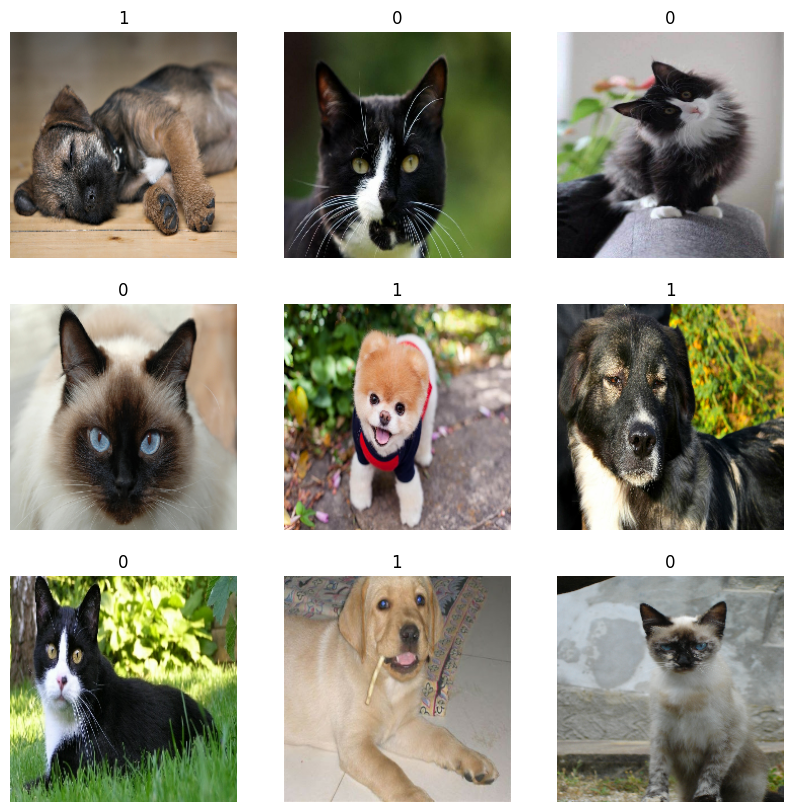

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

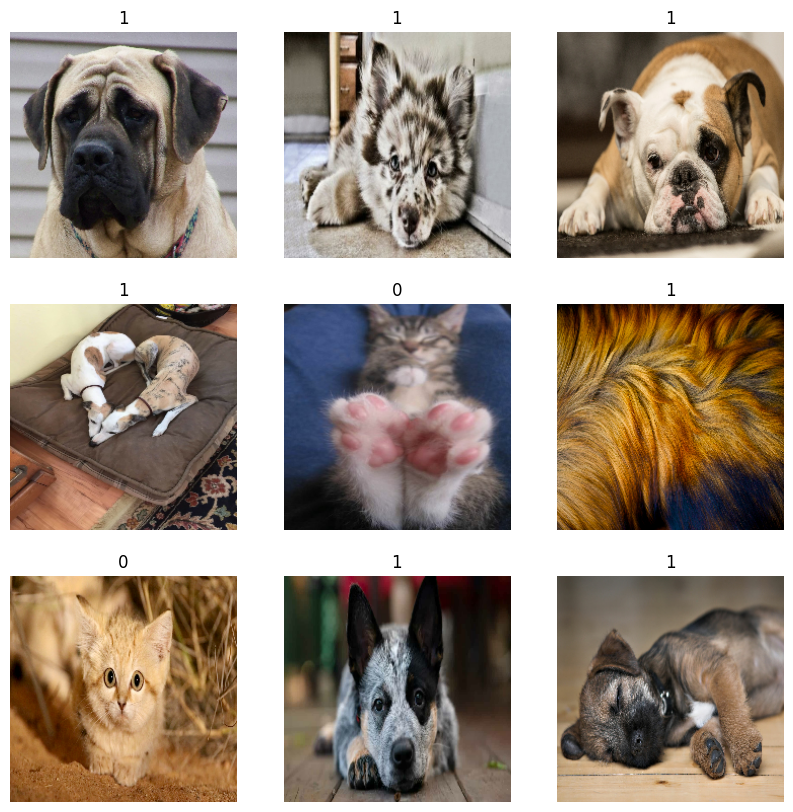

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in val_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

### Augmentation
- using flip and rotation

In [11]:
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.1),
    ]
)

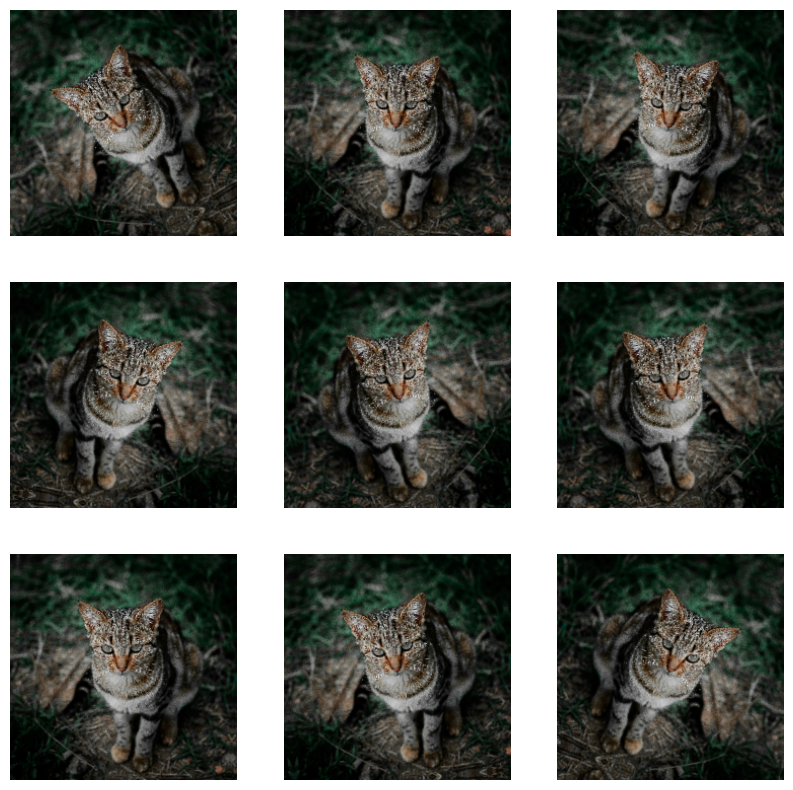

In [12]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images, training=True)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [13]:
augmented_train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y))

## Model

In [55]:
# mlflow.tensorflow.autolog()

In [56]:
base_model = MobileNet(input_shape=config['input_shape'], include_top=False, weights="imagenet")
base_model.trainable = False
model = keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(2, activation="softmax")
])

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=config['learning_rate']),
    metrics=["accuracy"],
)


In [57]:
logdir = os.path.join("logs", experiment_name, run_name)
tb_callback = keras.callbacks.TensorBoard(log_dir=logdir, write_graph=True, histogram_freq=1)

In [ ]:
history = model.fit(
    augmented_train_dataset,
    epochs=config['num_epochs'],
    validation_data=val_dataset,
    verbose=2,
    callbacks=[tb_callback]
)

In [61]:
mlflow.set_experiment(experiment_name)
with mlflow.start_run(run_name = run_name) as mlflow_run:
    
    mlflow.set_experiment_tag("base_model", "MobileNet")
    mlflow.set_tag("optimizer", "keras.optimizers.Adam")
    mlflow.set_tag("loss", "sparse_categorical_crossentropy")

    mlflow.keras.log_model(model, "model")

    mlflow.log_param("learning_rate", config["learning_rate"])
    mlflow.log_param("num_epochs", config["num_epochs"])
    mlflow.log_param("batch_size", config["batch_size"])
    mlflow.log_param("input_shape", config["input_shape"])

    mlflow.log_metric("train_loss", history.history["loss"][-1])
    mlflow.log_metric("train_acc", history.history["accuracy"][-1])
    mlflow.log_metric("val_loss", history.history["val_loss"][-1])
    mlflow.log_metric("val_acc", history.history["val_accuracy"][-1])


    mlflow_run_id = mlflow_run.info.run_id
    print("MLFlow Run ID: ", mlflow_run_id)

2024/04/12 10:12:29 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\grego\AppData\Local\Temp\tmpc1kmqzlg\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\grego\AppData\Local\Temp\tmpc1kmqzlg\model\data\model\assets


MLFlow Run ID:  7bc2842354be4215aaa874136561f711


In [65]:
!mlflow ui

^C


In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/cat-dog-classifier-mobilenet

In [17]:
img = keras.preprocessing.image.load_img(
    os.path.join(image_path, "cat/Image_23.jpg"), target_size=config['input_shape']
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 
img_array.shape

TensorShape([1, 224, 224, 3])

1/1 [==============================] - 0s 26ms/step
This image is 100.00% cat and 0.00% dog.


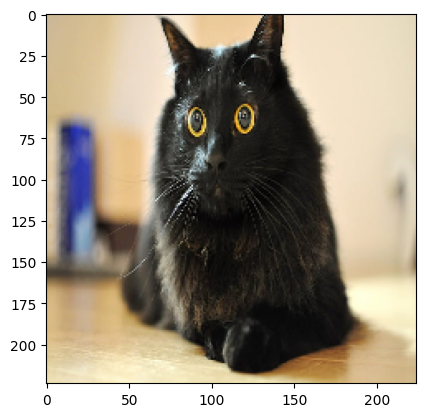

In [30]:
predictions = model.predict(img_array)
print("This image is {:.2f}% cat and {:.2f}% dog.".format(100 * float(predictions[0][0]),
                                                          100 * float(predictions[0][1])))

plt.imshow(img_array[0].numpy().astype("uint8"))

In [ ]:
# Logged model in MLFlow
logged_model_path = f"runs:/{mlflow_run_id}/model"

print("Model saved in MLFlow:", logged_model_path)
# Load model as a Keras model
loaded_model = mlflow.keras.load_model(logged_model_path)

1/1 [==============================] - 0s 300ms/step
This image is 100.00% cat and 0.00% dog.


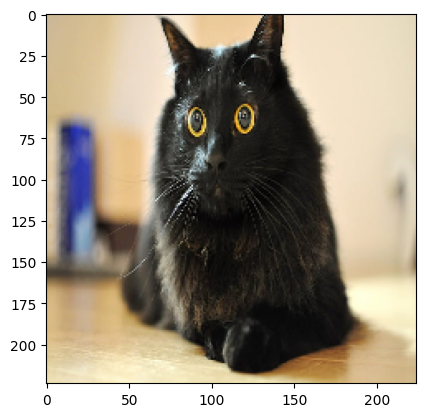

In [21]:
predictions = loaded_model.predict(img_array)
print("This image is {:.2f}% cat and {:.2f}% dog.".format(100 * float(predictions[0][0]),
                                                          100 * float(predictions[0][1])))

plt.imshow(img_array[0].numpy().astype("uint8"))

## Model Registration

In [15]:
model_name = "cat_dog_classifier"
model_version = 1

In [49]:
print("MLFlow Run ID: ", mlflow_run_id)

MLFlow Run ID:  88b9f247cc824366b4a54e44b5fff96d


In [50]:
with mlflow.start_run(run_id=mlflow_run_id) as run:
    result = mlflow.register_model(
        logged_model_path,
        model_name
    )

Registered model 'cat_dog_classifier' already exists. Creating a new version of this model...
Created version '2' of model 'cat_dog_classifier'.


1/1 [==============================] - 0s 292ms/step
This image is 100.00% cat and 0.00% dog.


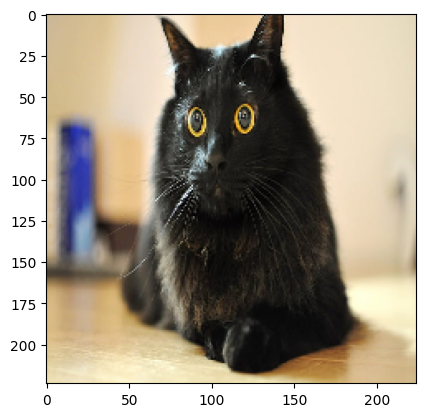

In [18]:
loaded_model = mlflow.keras.load_model(
    model_uri=f"models:/{model_name}/{model_version}"
)

predictions = loaded_model.predict(img_array)
print("This image is {:.2f}% cat and {:.2f}% dog.".format(100 * float(predictions[0][0]),
                                                          100 * float(predictions[0][1])))

plt.imshow(img_array[0].numpy().astype("uint8"))

## Transation Model to Production

In [20]:
client = mlflow.tracking.MlflowClient()
client.transition_model_version_stage(
    name=model_name,
    version=model_version,
    stage="Production"
)

C:\Users\grego\AppData\Local\Temp\ipykernel_22416\163353590.py:2: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.11.3/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


<ModelVersion: aliases=[], creation_timestamp=1712926340341, current_stage='Production', description=None, last_updated_timestamp=1712928223214, name='cat_dog_classifier', run_id='a2cd9e018566400990a526a99e6bebe9', run_link=None, source='file:///d:/study/github/Learning-MLFlow/notebooks/mlruns/808558003008823482/a2cd9e018566400990a526a99e6bebe9/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=1>

d:\softs\conda\envs\github\lib\site-packages\mlflow\store\artifact\utils\models.py:32: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.11.3/model-registry.html#migrating-from-stages
  latest = client.get_latest_versions(name, None if stage is None else [stage])


1/1 [==============================] - 0s 262ms/step
This image is 100.00% cat and 0.00% dog.


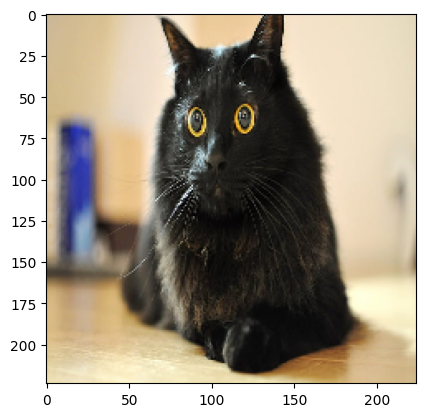

In [21]:
# Load model as a Keras model
loaded_model = mlflow.keras.load_model(
    model_uri=f"models:/{model_name}/production"
)

predictions = loaded_model.predict(img_array)
print("This image is {:.2f}% cat and {:.2f}% dog.".format(100 * float(predictions[0][0]),
                                                          100 * float(predictions[0][1])))

plt.imshow(img_array[0].numpy().astype("uint8"))

## Create endpoint for model serving

- Set environment variable for MLFlow URI  
`export MLFLOW_TRACKING_URI=http://localhost:5000`

- Start MLFlow Server for the model  
`mlflow models serve --model-uri models:/cat_dog_classifier/production -p 7777 --no-conda`

In [22]:
endpoint = "http://localhost:7777/invocations"

This image is 100.00% cat and 0.00% dog.


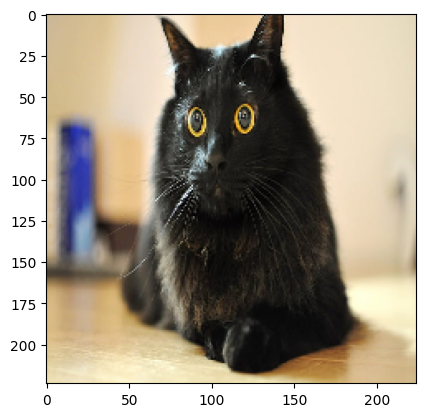

In [23]:
image_request = {
        "instances":img_array.numpy().tolist()
}

response = requests.post(endpoint, json=image_request)

predictions = eval(response.text)["predictions"] # eval is a function that evaluates the list of predictions
print("This image is {:.2f}% cat and {:.2f}% dog.".format(100 * float(predictions[0][0]),
                                                          100 * float(predictions[0][1])))

plt.imshow(img_array[0].numpy().astype("uint8"))